## Download Exsiting Dataset and Seperate the Movie Items

If you want to reproduce the code, please download and extract the following dataset, and put it into the `data` folder.

- https://datasets.imdbws.com/title.basics.tsv.gz
- https://datasets.imdbws.com/title.crew.tsv.gz
- https://datasets.imdbws.com/title.ratings.tsv.gz

### 1.1 Because in raw title.basics there are not only movies, but also tv series and etc.

First we have to filter out all the movies, the movie data will be stored in `movie_list.csv`.

In [2]:
from tqdm import tqdm

file_basics = open('../data/title.basics.tsv','r')
file_movie_list = open('../data/movie_list.tsv','w')

# write header
line = file_basics.readline().split('\t')
file_movie_list.write('\t'.join([line[0],line[2],line[5],line[7],line[8]]))

# filter out all the movies with available Year Run_time
for line in tqdm(file_basics):
    line = line.split('\t')
    if line[1] == 'movie' and line[2]!='\\N' and line[5]!='\\N' and line[7]!='\\N':
        file_movie_list.write('\t'.join([line[0],line[2],line[5],line[7],line[8]]))
file_basics.close()
file_movie_list.close()

6218835it [00:06, 1023605.31it/s]


### 1.2 Overview of the Movie Data

After we filter out movies, let us see the distribution of movies on Years and Run time

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_movie_list = pd.read_csv('../data/movie_list.tsv', delimiter='\t')
file_movie_list.describe()

,startYear,runtimeMinutes
count,329291.000000,329291.000000
mean,1992.112016,88.330622
std,25.882660,146.499533
min,1894.000000,1.000000
25%,1976.000000,72.000000
50%,2003.000000,88.000000
75%,2013.000000,100.000000
max,2022.000000,59460.000000


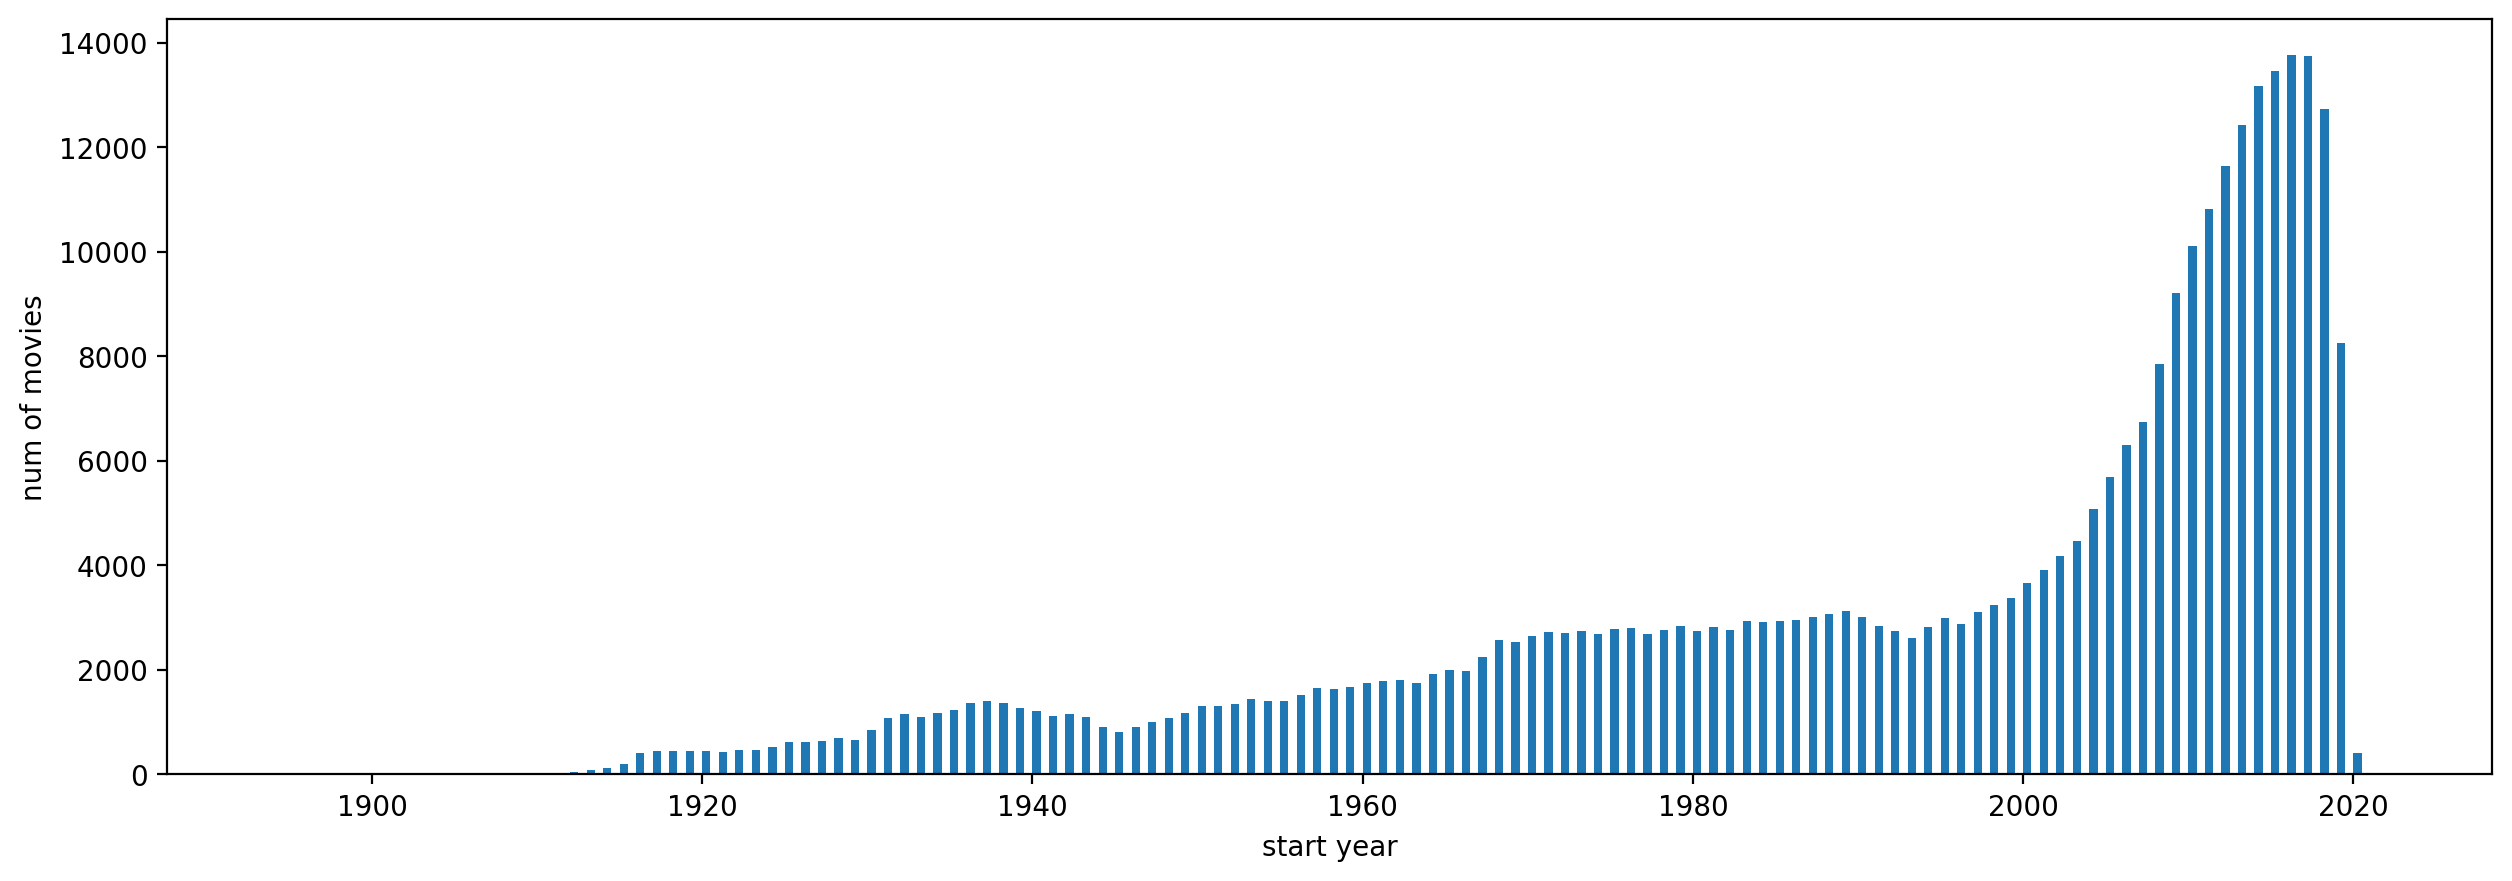

In [9]:
plt.figure(figsize=(15,5), dpi=200)
plt.hist(file_movie_list["startYear"],bins=256)
plt.xlabel("start year")
plt.ylabel("num of movies")
plt.show()

### 1.3 Select the movies from 2000 to 2018 and with run time between 1 hour to 3 hours 

According to the year distribution, we are going to keep the data which release years are between 2000 to 2018, and running times are between 60mins to 180 mins.

In [10]:
file_movie_list[(file_movie_list['startYear']>=2000) &
                (file_movie_list['startYear']<=2018) &
                (file_movie_list['runtimeMinutes']<=180) &
                (file_movie_list['runtimeMinutes']>=60)].to_csv(
    '../data/movie_2000_to_2018.tsv', sep='\t', index=None)

In [11]:
file_movie_list = pd.read_csv('../data/movie_2000_to_2018.tsv', delimiter='\t')
file_movie_list.describe()

,startYear,runtimeMinutes
count,140853.000000,140853.000000
mean,2011.176482,93.231049
std,4.991285,20.118494
min,2000.000000,60.000000
25%,2008.000000,80.000000
50%,2012.000000,90.000000
75%,2015.000000,102.000000
max,2018.000000,180.000000


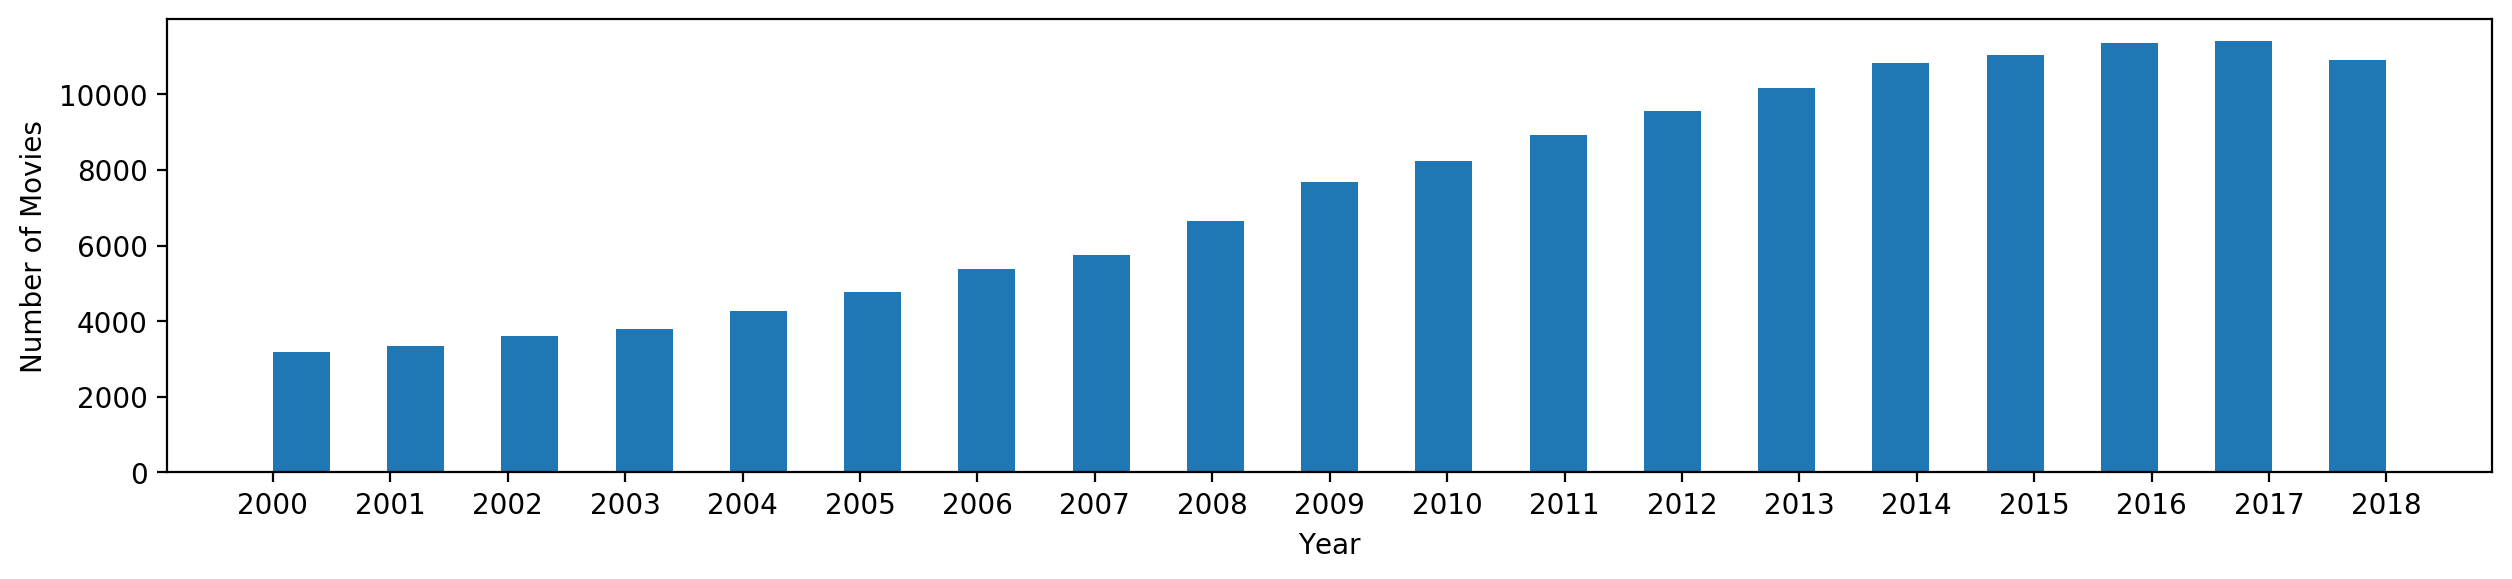

In [19]:
year = np.arange(2000,2019)
plt.figure(figsize=(15,3),dpi=200)
plt.hist(file_movie_list["startYear"],bins=37)
plt.xticks(year)
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.show()

### 1.4 Add Some Fields from Another Dataset

Then we add writers, directors from title.crew.tsv to this data set and save it to `movie_2000_to_2018_add_crew.tsv`.

In [ ]:
file_crew = pd.read_csv('../data/title.crew.tsv', sep='\t', index_col=0)
file_movie_2000_to_2018 = pd.read_csv('../data/movie_2000_to_2018.tsv', sep='\t', index_col=0)

file_movie_2000_to_2018_add_crew = pd.concat([file_movie_2000_to_2018, file_crew], axis=1, join="inner")
file_movie_2000_to_2018_add_crew.to_csv("../data/movie_2000_to_2018_add_crew.tsv", sep='\t')

Then we add rating, numVoters from title.ratings.tsv to this data set and save it to `movie_2000_to_2018_add_crew_rating.tsv`.

In [9]:
file_ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t', index_col=0)
file_movie_2000_to_2018_add_crew = pd.read_csv('../data/movie_2000_to_2018_add_crew.tsv', sep='\t', index_col=0)

file_movie_2000_to_2018_add_crew_rating = pd.concat([file_movie_2000_to_2018_add_crew, file_ratings], axis=1, join="inner")
file_movie_2000_to_2018_add_crew_rating.to_csv("../data/movie_2000_to_2018_add_crew_rating.tsv", sep='\t')

### 1.5 Run Crawler to Fetch More Related Information

Till now, we have the latest dataset `file_movie_2000_to_2018_part_2` including crew, rating information.

The next step is to run the crawler, and retrieve poster and other information such as budget, box office, storyline and stars from IMDb webpages.

```
cd project-folder/crawler

pip3 install -r requirements.txt

python spider.py
```

Then you will get two new files named `spider_info` and `spider_storyline` in crawler dir.
And the posters are stored at `data/posters`

### 1.6 Exchange different currencies into USD type

In spider_info, there are other currencies like EUR that need to be changed into USD.

To simplify the task, I took the average of each currency to USD ratio in 2000 and 2018 found on Yahoo as the exchange rate.

In [10]:
import re

currency = {}
f_info = open("../crawler/spider_info.tsv",'r')

for line in f_info:
    budget = line.split('\t')[1]
    if budget[0] == '$':
        continue
    else:
        budget_currency = re.search('[A-Z][A-Z][A-Z]', budget)
        try:
            currency[budget_currency.group(0)] += 1
        except:
            currency[budget_currency.group(0)] = 1

f_info.close()

print(currency)

change = {'EUR' : (0.8643+1.1593)/2,
      'AUD' : (0.5324+0.7141)/2,
      'CAD' : (0.6629+0.7710)/2,
      'BRL' : (0.5378+0.2686)/2,
      'GBP' : (1.4727+1.3166)/2,
      'INR' : (0.0216+0.0135)/2,
      'CNY' : (0.1208+0.1445)/2,
      'HKD' : (0.1283+0.1276)/2,
      'DKK' : (0.1161+0.1553)/2,
      'NOK' : (0.1161+0.1553)/2,
      'HUF' : (0.0032+0.0035)/2,
      'JPY' : (0.0093+0.0089)/2,
      'ZAR' : (0.1340+0.0696)/2,
      'SGD' : (0.5700+0.7271)/2,
      }

f_info = open("../crawler/spider_info.tsv",'r')
f_info_digit = open("../crawler/spider_info_digit.tsv",'w')
f_info_digit.write("tconst	Budget	Box_Office	Star_1	Star_2	Star_3	Star_num1	Star_num2	Star_num3\n")
for line in f_info:
    line = line.split('\t')
    line[1] = line[1].replace(',','')
    line[2] = line[2].replace(',','')
    line[2] = line[2][1:]
    if line[1][0] == '$': 
        line[1] = line[1][1:]
    else:
        try:
            line[1] = str(int(change[line[1][:3]] * int(line[1][3:])))

        except:
            continue
    f_info_digit.write('\t'.join(line))

f_info.close()
f_info_digit.close()

{'EUR': 1667, 'FRF': 39, 'AUD': 81, 'DEM': 14, 'CAD': 94, 'BRL': 72, 'SEK': 51, 'GBP': 208, 'ITL': 3, 'CZK': 29, 'INR': 285, 'FIM': 6, 'NLG': 1, 'ATS': 1, 'CNY': 56, 'HKD': 34, 'DKK': 53, 'BND': 1, 'NOK': 108, 'ESP': 1, 'HUF': 29, 'JPY': 20, 'ZAR': 36, 'SGD': 24, 'PLN': 35, 'KRW': 31, 'EGP': 30, 'EEK': 3, 'THB': 18, 'MXN': 26, 'NZD': 19, 'CHF': 7, 'TWD': 15, 'BGL': 5, 'LVL': 5, 'RUR': 32, 'MYR': 21, 'PHP': 7, 'TRL': 32, 'ISK': 5, 'ARS': 24, 'IDR': 3, 'VEB': 5, 'LTL': 1, 'CLP': 3, 'PEN': 1, 'PKR': 4, 'UAH': 8, 'COP': 4, 'HRK': 1, 'RON': 1, 'IRR': 4, 'DOP': 4, 'ILS': 1, 'AMD': 1, 'VND': 1, 'BDT': 1, 'AED': 1, 'NGN': 1}


### 1.7 Concat storyline, box office and other info into one file



In [11]:
f_digit = pd.read_csv('../crawler/spider_info_digit.tsv', sep='\t', index_col=0)
f_part_2 = pd.read_csv('../data/movie_2000_to_2018_add_crew_rating.tsv', sep='\t', index_col=0)
f_story = pd.read_csv('../crawler/spider_story.tsv', sep='\t', index_col=0)


for row in f_story.iterrows():
    row[1]['Story_Line'] = row[1]['Story_Line'].split(' Written by')[0]

imdb = pd.concat([f_digit, f_part_2, f_story], axis = 1, join='inner')

### 1.8 We add Ratio and Ratio Bool into dataset

What we are going to do is to predict the rating of a movie and whether it is profitable. So we calculate the `Ratio = Box Office / Budget`. If Ratio > 1, then the movie is profitable, otherwise it is non-profitable. 

In [12]:
imdb['Ratio'] = imdb['Box_Office'] / (imdb['Budget'] + 1)
imdb['Profitable'] = imdb['Ratio'] >= 1
imdb = imdb.drop(imdb[(imdb['Ratio']>10) | (imdb['Budget'] < 10000) | (imdb['Ratio']<0.05)].index)
imdb.to_csv('../data/imdb.tsv', sep='\t')

### Split imdb.tsv into train.tsv and val.tsv

if you want to retrain the model, you can split the imdb.tsv.

If you just want to validate the trained model downloading from github, you should use the matched train.tsv and val.tsv on github. Otherwise, spliting new dataset will cause error because the training and validating dataset are changed.

In [ ]:
train = imdb.sample(frac=0.8)
val = imdb.drop(train.index)
train.to_csv("../data/train.tsv",sep='\t',index=None)
val.to_csv("../data/val.tsv",sep='\t',index=None)